In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import matplotlib.patches as patches
from ect import ECT, EmbeddedGraph # for figure illustrations we used ect package instead of dect

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
import networkx as nx

plt.rcParams.update({
    'font.size': 14,              # tamaño base de fuente
    'axes.titlesize': 16,         # tamaño del título del gráfico
    'axes.labelsize': 14,         # etiquetas de los ejes
    'xtick.labelsize': 12,        # tamaño de los ticks en el eje x
    'ytick.labelsize': 12,        # tamaño de los ticks en el eje y
    'legend.fontsize': 13,        # tamaño de la leyenda
    'figure.titlesize': 16,       # título general (si usas suptitle)
})

## Euler Characteristic Transform illustration from molecule smile.

#### Option 1: My initial idea 

In this case, we use as an example the [acetic acid](https://en.wikipedia.org/wiki/Acetic_acid) molecule and its smile, which it is CC(O)=O. You can use as tutorial for the ECT and this plots, the following repository I made: https://github.com/victosdur/EulerCharacteristicTransform_Tutorial/blob/main/ect/tutorial.ipynb

1) Molecule graph, with smile and EC in the title, and directions in the plot.

2) Filtration values for an specific direction

3) ECC for this specific direction and filtration values

4) ECT for the combination of directions



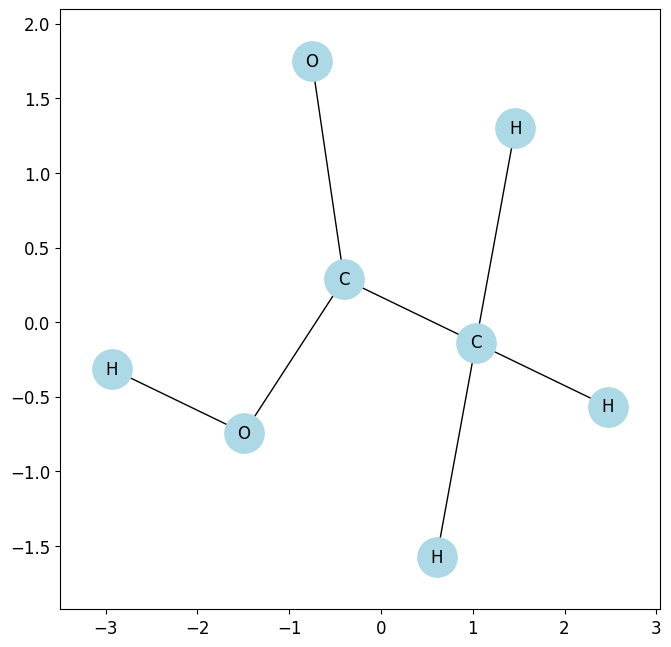

In [2]:
aceticAcidSmile = "CC(O)=O"

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(aceticAcidSmile)
mol = Chem.AddHs(mol)  # Add hydrogens if desired

# Compute 2D coordinates (always the same with same seed, for molecule visualization is super nice)
rdDepictor.Compute2DCoords(mol)

# Access node (atom) information
atom_info = {}
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    atom_info[idx] = {
        "symbol": atom.GetSymbol(),
        "atomic_num": atom.GetAtomicNum(),
        "is_aromatic": atom.GetIsAromatic(),
    }

# In case you want to see the atom information
# print("Atom info:")
# for idx, info in atom_info.items():
#     print(f"Atom {idx}: {info}")

# Build molecule graph with NetworkX
G = nx.Graph()
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    G.add_node(idx, **atom_info[idx])

for bond in mol.GetBonds():
    start = bond.GetBeginAtomIdx()
    end = bond.GetEndAtomIdx()
    G.add_edge(start, end, bond_type=str(bond.GetBondType()))

# Get 2D coordinates for layout
conf = mol.GetConformer()
pos = {i: (conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y) for i in range(mol.GetNumAtoms())}

# Plot the molecular graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_color='lightblue', node_size=800, font_size=10)
nx.draw_networkx_labels(G, pos, labels={atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}, font_color='black')
# plt.title(f"Graph of molecule: {aceticAcidSmile}")
plt.axis('on')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

The radius of bounding circle centered at the origin is 2.7787759390759796


<Figure size 600x600 with 0 Axes>

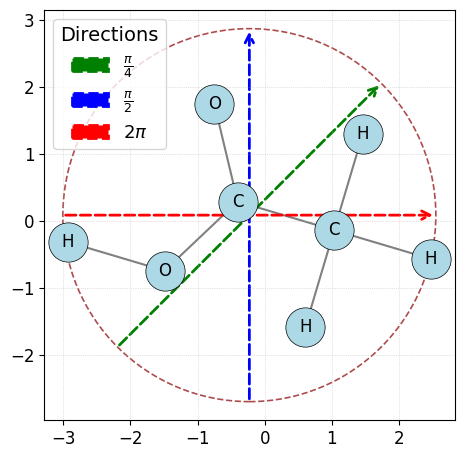

In [5]:
Graphect = EmbeddedGraph()
for nodeKey in pos:
    Graphect.add_node(nodeKey, [pos[nodeKey][0], pos[nodeKey][1]])
for edge in G.edges:
    Graphect.add_edge(edge[0], edge[1])

xcenter, ycenter = Graphect.get_center()
directions = [np.pi/4, np.pi / 2, 2*np.pi]
directionsLatex = [r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$2\pi$']
color=["green", "blue", "red"]
r = Graphect.get_bounding_radius()
print(f'The radius of bounding circle centered at the origin is {r}')

plt.figure(figsize=(6, 6))
Graphect.plot(with_labels=False,node_size=800,bounding_circle=True)
nx.draw_networkx_labels(G, pos, labels={atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}, font_color='black')



for i, theta in enumerate(directions):
    dx = r * np.cos(theta)
    dy = r * np.sin(theta)

    x_start = xcenter - dx
    y_start = ycenter - dy
    x_end = xcenter + dx
    y_end = ycenter + dy

    # plt.plot([x_start, x_end], [y_start, y_end], '--', color=color[i], linewidth=2) # sin flecha
    arrow = patches.FancyArrowPatch(
        (x_start, y_start), (x_end, y_end),
        arrowstyle='->',
        linestyle='--',          # Línea discontinua
        color=color[i],
        linewidth=2,
        mutation_scale=15,
        label=directionsLatex[i],  # Etiqueta de la flecha
    )
    
    plt.gca().add_patch(arrow)
# plt.title(f"Molecule graph with 8 vertices and 7 edges; $\chi=1$")
plt.axis('on')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.tight_layout()
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend(title="Directions")
plt.savefig('figures/IllustrationPaper/MoleculeGraphWithDirections.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 600x600 with 0 Axes>

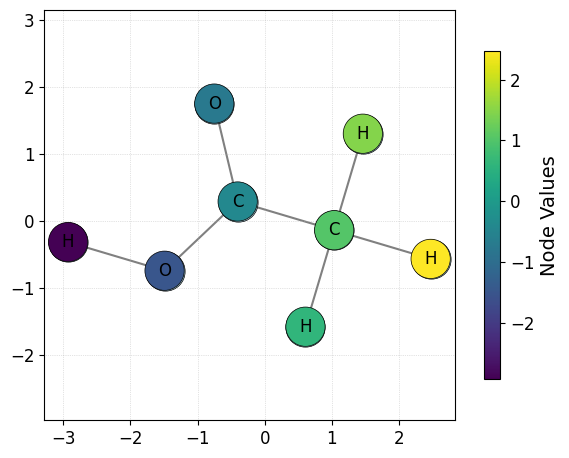

In [8]:
plt.figure(figsize=(6, 6))
Graphect.plot(color_nodes_theta=directions[1],with_labels=False,node_size=800)
nx.draw_networkx_labels(G, pos, labels={atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}, font_color='black')
plt.xlim(xlims)
plt.ylim(ylims)
plt.axis('on')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# plt.title(f"Filtration values of molecule graph for direction {directionsLatex[0]}")
plt.tight_layout()
plt.savefig('figures/IllustrationPaper/FiltrationExample.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
myect = ECT(num_dirs=3, thresholds=np.linspace(-4,4,35))
print(f"Number of directions: {myect.num_dirs}")
print(f"Number of thresholds: {myect.num_thresh}")

result = myect.calculate(Graphect)

Number of directions: 3
Number of thresholds: None


In [25]:
myect.thresholds

array([-4.        , -3.76470588, -3.52941176, -3.29411765, -3.05882353,
       -2.82352941, -2.58823529, -2.35294118, -2.11764706, -1.88235294,
       -1.64705882, -1.41176471, -1.17647059, -0.94117647, -0.70588235,
       -0.47058824, -0.23529412,  0.        ,  0.23529412,  0.47058824,
        0.70588235,  0.94117647,  1.17647059,  1.41176471,  1.64705882,
        1.88235294,  2.11764706,  2.35294118,  2.58823529,  2.82352941,
        3.05882353,  3.29411765,  3.52941176,  3.76470588,  4.        ])

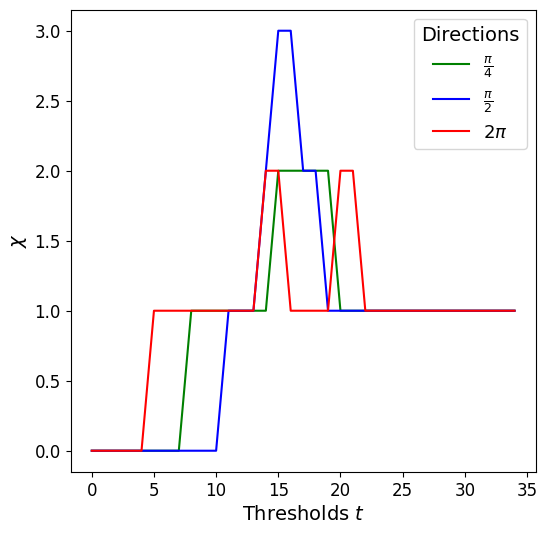

In [26]:
vectors = [myect.calculate(Graphect, theta=theta).squeeze() for theta in directions] # es lo mismo que las siguientes 3 lineas pero ya apiladas
# print(myect.calculate(Graphect, theta=directions[0]))
# print(myect.calculate(Graphect, theta=directions[1]))
# print(myect.calculate(Graphect, theta=directions[2]))
plt.figure(figsize=(6, 6))
for i, ecc in enumerate(vectors):
    plt.plot(ecc, color=color[i], label=directionsLatex[i])
plt.legend(title="Directions")
# plt.title("Euler Characteristic Curves") 
plt.xlabel("Thresholds $t$")
plt.ylabel("$\chi$")
plt.savefig("figures/IllustrationPaper/MoleculeECCs.png", dpi=300, bbox_inches='tight')
plt.show()
matrix = np.stack(vectors, axis=1)

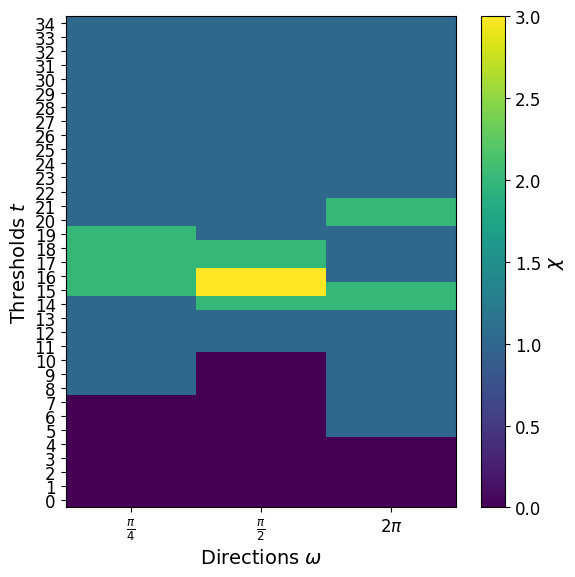

In [27]:
plt.figure(figsize=(6, 6))
plt.imshow(matrix, aspect='auto', cmap='viridis', origin="lower")  # o cualquier colormap
plt.colorbar(label='$\chi$')	

# Etiquetas en columnas: ángulos
plt.xticks(ticks=range(len(directions)), labels=[f"{i}" for i in directionsLatex])
plt.yticks(ticks=range(matrix.shape[0]), labels=[str(i) for i in range(matrix.shape[0])])
plt.xlabel("Directions $\omega$")
plt.ylabel("Thresholds $t$")
# plt.title("Euler Characteristic Transform Matrix")
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeECT.png", dpi=300, bbox_inches='tight')
plt.show()


# Option 2, following Bastian suggestion. 

(Not showing directions, more specific filtration example, single ECC, and later separately an example of ECT.)

1) Molecule graph, with smile and EC in the title, and directions in the plot.

2) Filtration example for x-axis direction for example

3) ECC for this specific direction and filtration

4) ECT stacking multiple ECC from different directions

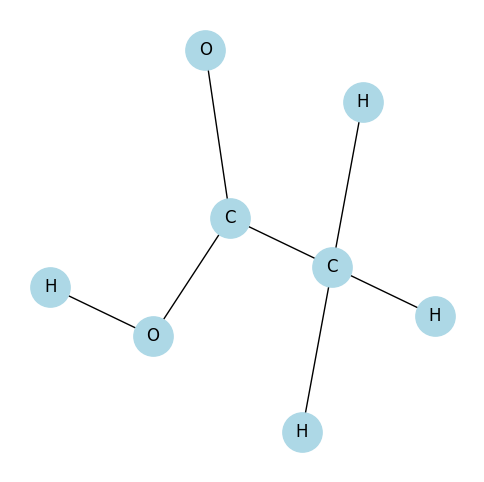

In [171]:
aceticAcidSmile = "CC(O)=O"

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(aceticAcidSmile)
mol = Chem.AddHs(mol)  # Add hydrogens if desired

# Compute 2D coordinates (always the same with same seed, for molecule visualization is super nice)
rdDepictor.Compute2DCoords(mol)

# Access node (atom) information
atom_info = {}
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    atom_info[idx] = {
        "symbol": atom.GetSymbol(),
        "atomic_num": atom.GetAtomicNum(),
        "is_aromatic": atom.GetIsAromatic(),
    }

# In case you want to see the atom information
# print("Atom info:")
# for idx, info in atom_info.items():
#     print(f"Atom {idx}: {info}")

# Build molecule graph with NetworkX
G = nx.Graph()
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    G.add_node(idx, **atom_info[idx])

for bond in mol.GetBonds():
    start = bond.GetBeginAtomIdx()
    end = bond.GetEndAtomIdx()
    G.add_edge(start, end, bond_type=str(bond.GetBondType()))

# Get 2D coordinates for layout
conf = mol.GetConformer()
pos = {i: (conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y) for i in range(mol.GetNumAtoms())}

# Plot the molecular graph
fig, ax = plt.subplots(1,1,figsize=(6, 6))
nx.draw(G, pos, node_color='lightblue', node_size=800, font_size=10)
nx.draw_networkx_labels(G, pos, labels={atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}, font_color='black')
# plt.title(f"Graph of molecule: {aceticAcidSmile}")
plt.axis('off')
# ax.spines[['right', 'top']].set_visible(False) # if you want to show axis, put previous line on and uncomment this one
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.savefig("figures/IllustrationPaper/moleculeGraph")
plt.show()
plt.close()

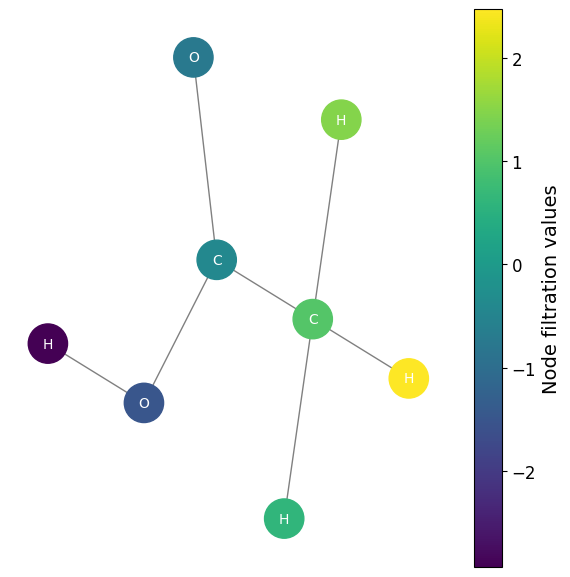

In [206]:
#node filtration values
x_coords = np.array([pos[i][0] for i in G.nodes()])
# Graficar con color de nodo basado en coordenada x
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Escoger un colormap adecuado
cmap = plt.cm.viridis

# Normalizar los valores para el colormap
norm = plt.Normalize(vmin=x_coords.min(), vmax=x_coords.max())
node_colors = cmap(norm(x_coords))

# Dibujar
nx.draw(G, pos, ax=ax, node_color=node_colors, node_size=800, edge_color='gray')
labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}
nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=10)

# Mostrar barra de color (opcional)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Node filtration values")

# Ajustes finales
plt.axis('off')
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeGraphFiltrationValuesExample", dpi=300)
plt.show()
plt.close()

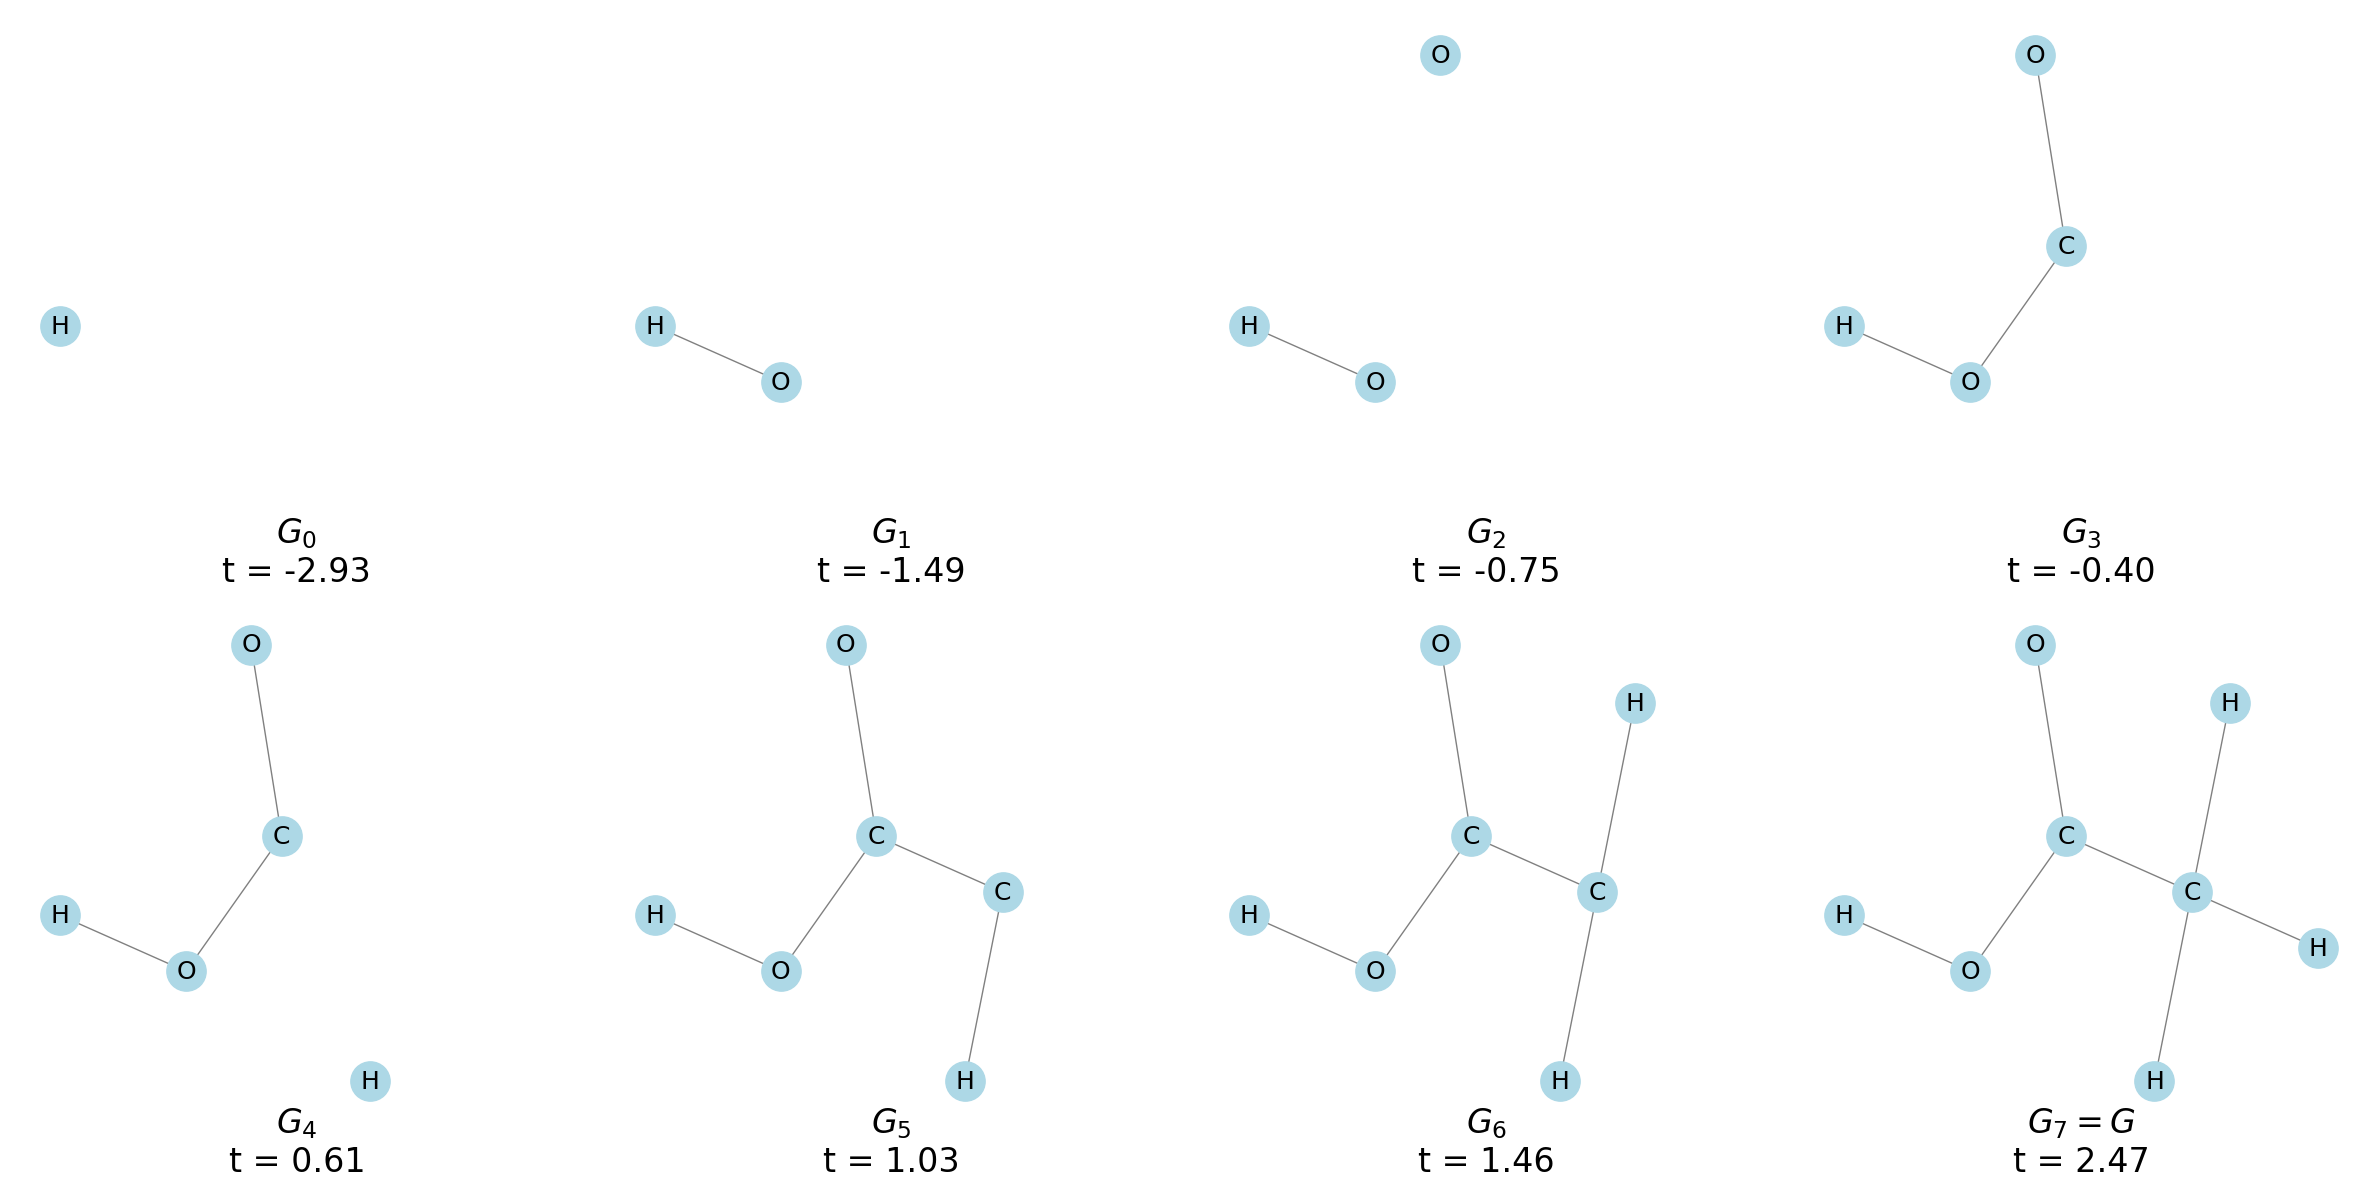

In [245]:
# Usar coordenada x como filtración direccional
node_filtration = {i: pos[i][0] for i in G.nodes()}
filtration_times = sorted(set(node_filtration.values()))

fig, axes = plt.subplots(2, 4, figsize=(6*4, 12))
axes = axes.flatten()

# Dibujar cada paso de la filtración
for i, t in enumerate(filtration_times):
    ax = axes[i]
    # Nodos activos
    active_nodes = [n for n, val in node_filtration.items() if val <= t]
    # Aristas activas
    active_edges = [(u, v) for u, v in G.edges() if u in active_nodes and v in active_nodes]

    subG = G.subgraph(active_nodes)
    active_pos = {n: pos[n] for n in subG.nodes()}
    nx.draw(subG, active_pos, ax=ax, with_labels=False, node_color='lightblue', node_size=800, edge_color='gray')
    
    for n in subG.nodes():
        x, y = active_pos[n]
        ax.text(x, y, G.nodes[n]["symbol"], fontsize=18, ha='center', va='center', color='black')

    if i == len(node_filtration)-1:
        ax.set_title(f"$G_{i}=G$\nt = {t:.2f}",fontsize=24,y=-0.1)
    else:
        ax.set_title(f"$G_{i}$\nt = {t:.2f}",fontsize=24,y=-0.1)
        
    
    # ax.set_axis_on()
    # ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
# Borrar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# fig.suptitle("Filtration sequence", fontsize=24)
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeFiltrationSequenceAxisX")
# plt.subplots_adjust(top=0.90)
plt.show()
plt.close()

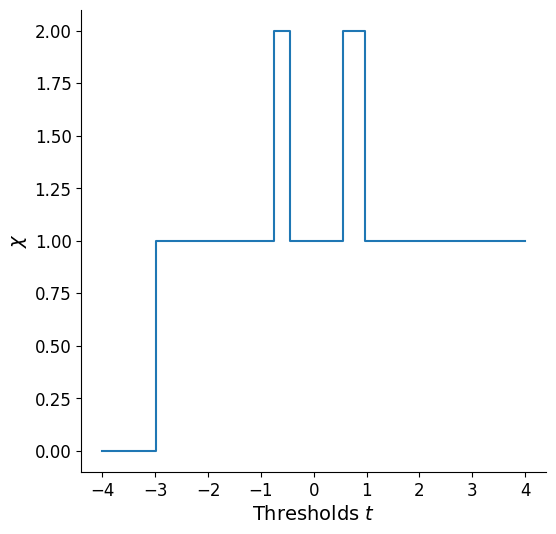

In [239]:
Graphect = EmbeddedGraph()
for nodeKey in pos:
    Graphect.add_node(nodeKey, [pos[nodeKey][0], pos[nodeKey][1]])
for edge in G.edges:
    Graphect.add_edge(edge[0], edge[1])

myect = ECT(num_dirs=10, thresholds=np.linspace(-4,4,80))
ect = myect.calculate(Graphect)

ecc = myect.calculate(Graphect, theta=2*np.pi).squeeze()
directions=myect.directions
thresholds=myect.thresholds

fig, ax = plt.subplots(1,1,figsize=(6, 6))
plt.step(thresholds,ecc)
plt.xlabel("Thresholds $t$")
plt.ylabel("$\chi$")
plt.axis('on')
ax.spines[['right', 'top']].set_visible(False) 
plt.savefig("figures/IllustrationPaper/MoleculeECC.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

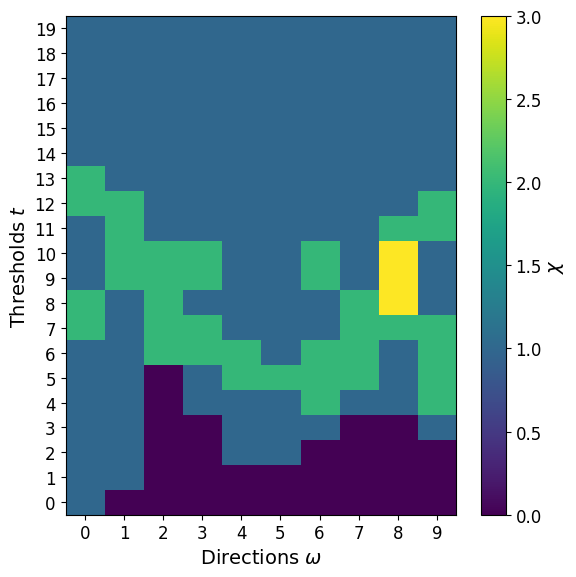

In [238]:
myect = ECT(num_dirs=10, num_thresh=20)
ect = myect.calculate(Graphect)
directions=myect.directions
thresholds=myect.thresholds


plt.figure(figsize=(6, 6))
plt.imshow(ect.transpose(), aspect='auto', cmap='viridis', origin="lower")  # o cualquier colormap
plt.colorbar(label='$\chi$')	

# Etiquetas en columnas: ángulos
plt.yticks(ticks=range(len(thresholds)), labels=np.round(thresholds,2))
plt.yticks(ticks=range(len(thresholds)), labels=np.arange(0,len(thresholds)))
plt.xticks(ticks=range(len(directions)), labels=np.arange(0,len(directions)))
plt.xlabel("Directions $\omega$")
plt.ylabel("Thresholds $t$")
# plt.title("Euler Characteristic Transform Matrix")
plt.tight_layout()
plt.savefig("figures/IllustrationPaper/MoleculeECT2.png", dpi=300, bbox_inches='tight')
plt.show()